### Random Selection Experiment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import t
from scipy.stats import uniform
from scipy.stats import ttest_1samp # library for p-value estimation
import ruptures as rpt # library for change point detection
%matplotlib inline
import matplotlib.patheffects as mpe
%run ./Experiment_Functions.ipynb
# load functions for the creation of the different distributions

In [2]:
# for visulaization purposes
def replace_outlier(val, mean, std, const=5):
    if val > mean + const*std:
        return mean + const*std 
    elif val < mean - const*std:
        return mean - const*std
    return val

In [3]:
# define arms
def quick_sort(df):
    sorted_df = df.sort_values(kind="quicksort")
    return sorted_df
def merge_sort(df):
    sorted_df = df.sort_values(kind="mergesort")
    return sorted_df
def heap_sort(df):
    sorted_df = df.sort_values(kind="heapsort")
    return sorted_df

In [4]:
choices = [quick_sort,merge_sort,heap_sort]
choices_names = ["quick_sort","merge_sort","heap_sort"]
dist_types = ["Uniform","Normal","Uniform_Sorted","Uniform_Reverse_Sorted","Uniform_Nearly_Sorted","Zipf", "Dates", "Strings", "Discrete_Uniform", "Discrete_Binomial", "Poisson"]

In [23]:
def plot_dataset(data):
    plt.figure(figsize=(24,6))
    plt.plot(data.rolling(1024).mean(), label="CR863")
    plt.legend(fontsize=24, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel("Value",fontsize=26)
    plt.xlabel("Number of Observation",fontsize=26)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)

In [6]:
def plot_rewards_distribution_together(arm_rewards, bins = 20):
    for key in arm_rewards:    
        arm_rewards[key] = [i * (-1) for i in arm_rewards[key]]
    #arm_rewards["quick_sort"] = arm_rewards["quick_sort"]*(-1)
    #arm_rewards["merge_sort"] = arm_rewards["merge_sort"]*(-1)
    #arm_rewards["heap_sort"] = arm_rewards["heap_sort"]*(-1)
    plt.figure(figsize=(16,6))
    _, bin_edges_qs = np.histogram(arm_rewards["quick_sort"], density=True)
    _, bin_edges_ms = np.histogram(arm_rewards["merge_sort"], density=True)
    _, bin_edges_hs = np.histogram(arm_rewards["heap_sort"], density=True)
    plt.hist(arm_rewards["quick_sort"], bins=bin_edges_qs, alpha = 0.5, label='quick sort')
    plt.hist(arm_rewards["merge_sort"], bins=bin_edges_ms, alpha = 0.5, label='merge sort')
    plt.hist(arm_rewards["heap_sort"], bins=bin_edges_hs, alpha = 0.5, label='heap sort')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5) ,fontsize=26)
    plt.title("Distribution of runtimes during experiment",fontsize=26)
    plt.ylabel("Frequency",fontsize=26)
    plt.xlabel("Runtime in seconds",fontsize=26)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)

In [7]:
def plot_history(rewards,cum_rewards,chosen_arms):
    print("Arm Counts", chosen_arms)
    fig = plt.figure(figsize=[16,6])
    ax2 = fig.add_subplot(121)
    ax2.plot(cum_rewards, label="avg rewards")
    ax2.set_title("Cummulative Rewards",fontsize=18)
    ax2.set_ylabel('Reward (multiplied by -1)',fontsize=16)
    ax2.set_xlabel('Iteration',fontsize=16)
    plt.setp(ax2.get_xticklabels(), fontsize=14)
    plt.setp(ax2.get_yticklabels(), fontsize=14)
    labels = list(chosen_arms.keys())
    ax3 = fig.add_subplot(122)
    ax3.bar(chosen_arms.keys(), chosen_arms.values())
    ax3.set_title("Chosen Actions",fontsize=18)
    ax3.set_ylabel('Frequency',fontsize=16)
    ax3.set_xlabel('Action',fontsize=16)
    plt.setp(ax3.get_xticklabels(), fontsize=14)
    plt.setp(ax3.get_yticklabels(), fontsize=14)

In [83]:
def plot_history_iterations(history):
    df = pd.DataFrame.from_records(history,columns=["Iteration","Reward","Algorithm"])
    mean = df["Reward"].mean()
    std_dev = df["Reward"].std()
    df["Reward"] = df["Reward"].map(lambda x: replace_outlier(x, mean, std_dev))
    df["Reward"] = df["Reward"]*(-1)
    groups = df.groupby('Algorithm')
    # Plot
    dict_colors = {"quick_sort":'#1f77b4', "merge_sort":'#ff7f0e', "heap_sort":'#2ca02c'}
    plt.figure(figsize=(16,6))
    for name, group in groups:
        plt.plot(group.Iteration, group.Reward, marker='o', linestyle='', ms=10, alpha = 0.5, label=name, color=dict_colors[name])
    plt.legend(fontsize=26, loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.title("Algorithm choices during experiment",fontsize=26)
    plt.ylabel("Runtime in seconds",fontsize=26)
    plt.xlabel("Iteration",fontsize=26)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)

In [9]:
# help function to return the humber of consecutive elements in a list 
def count_consec(listrand):
    count=1
    consec_list=[]
    for i in range(len(listrand[:-1])):
        if listrand[i]+1 == listrand[i+1]:
            count+=1
        else:
            consec_list.append(count)
            count=1

    # Account for the last iteration
    consec_list.append(count)     

    return consec_list

In [10]:
def merge_sort_only(data, col, n_chunks=200):
    total_reward = 0
    num_choices = len(choices)
    arm_rewards = {"quick_sort": [], "merge_sort": [], "heap_sort":[]} 
    arm_counts = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0} 
    rewards = []
    cum_rewards = []
    history = []
    iteration = 0
    for chunk in np.array_split(data, n_chunks):
        alg = choices[1]
        #print(alg)
        start_time = time.perf_counter()
        sorted_dist = alg(chunk[col])
        reward = (time.perf_counter() - start_time)*(-1)
        #print(iteration, ":", alg.__name__, np.round(reward,4))
        total_reward += reward
        arm_rewards[alg.__name__].append(reward)
        arm_counts[alg.__name__] += 1
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        iteration+=1
        history.append([iteration, reward,alg.__name__])
    return total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history

In [11]:
def quick_sort_only(data,col, n_chunks=200):
    total_reward = 0
    num_choices = len(choices)
    arm_rewards = {"quick_sort": [], "merge_sort": [], "heap_sort":[]} 
    arm_counts = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0} 
    rewards = []
    cum_rewards = []
    history = []
    iteration = 0
    for chunk in np.array_split(data, n_chunks):
        alg = choices[0]
        #print(alg)
        start_time = time.perf_counter()
        sorted_dist = alg(chunk[col])
        reward = (time.perf_counter() - start_time)*(-1)
        #print(iteration, ":", alg.__name__, np.round(reward,4))
        total_reward += reward
        arm_rewards[alg.__name__].append(reward)
        arm_counts[alg.__name__] += 1
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        iteration+=1
        history.append([iteration, reward,alg.__name__])
    return total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history

In [12]:
def random_selection(data,col, n_chunks=200):
    total_reward = 0
    num_choices = len(choices)
    arm_rewards = {"quick_sort": [], "merge_sort": [], "heap_sort":[]} 
    arm_counts = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0} 
    rewards = []
    cum_rewards = []
    history = []
    iteration = 0
    for chunk in np.array_split(data, n_chunks):
        alg = np.random.choice(choices) 
        #print(alg)
        start_time = time.perf_counter()
        sorted_dist = alg(chunk[col])
        reward = (time.perf_counter() - start_time)*(-1)
        #print(iteration, ":", alg.__name__, np.round(reward,4))
        total_reward += reward
        arm_rewards[alg.__name__].append(reward)
        arm_counts[alg.__name__] += 1
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        iteration+=1
        history.append([iteration, reward,alg.__name__])
    return total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history

In [13]:
def epsilon_greedy(data, col, n_chunks=200, epsilon=0.01, constant_value=0.9):
    total_reward = 0
    num_choices = len(choices)
    arm_rewards = {"quick_sort": [], "merge_sort": [], "heap_sort":[]} 
    arm_counts = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0} 
    q_values = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0} 
    rewards = []
    cum_rewards = []
    history = []
    iteration = 0
    for n, chunk in enumerate(np.array_split(data, n_chunks)):
        alg = np.random.choice(choices) if np.random.random() < epsilon else choices[np.argmax(list(q_values.values()))]
        #print(alg)
        start_time = time.perf_counter()
        sorted_dist = alg(chunk[col])
        reward = (time.perf_counter() - start_time)*(-1)
        #print(iteration, ":", alg.__name__, np.round(reward,4))
        total_reward += reward
        arm_rewards[alg.__name__].append(reward)
        arm_counts[alg.__name__] += 1
        q_values[alg.__name__]  += constant_value*(reward-q_values[alg.__name__])
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        iteration+=1
        history.append([iteration, reward,alg.__name__])
    return total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history

In [14]:
def ucb(data, col, n_chunks=200, num_consec_elem=3, bound_const=0.001, quantile=0.025, list_length=5):
    total_reward = 0
    arm_rewards = {"quick_sort": [], "merge_sort": [], "heap_sort": []}  
    arm_rewards_temp = {"quick_sort": [], "merge_sort": [], "heap_sort": []}  
    arm_counts = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
    arm_counts_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
    ucb_values = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
    rewards = []
    cum_rewards = []
    num_choices = len(choices)
    bound_const = bound_const
    n_consecutive_list = []
    num_consec_elem = num_consec_elem
    iter_num = 0
    iteration = 0
    history = []
    number_of_restarts = 0
    restarts = []
    for n, chunk in enumerate(np.array_split(data, n_chunks)):
        for i in (choices_names):
                if arm_counts_temp[i] > 0: 
                    average_reward = np.mean(arm_rewards_temp[i])
                    #print("av_reward", average_reward, "for", choices_names[i])
                    delta_i = bound_const*math.sqrt(2 * math.log(iter_num) / arm_counts_temp[i])
                    #print("delta_i", delta_i, "for", choices_names[i])
                    ucb_values[i] = average_reward + delta_i
                elif arm_counts_temp[i] == 0:
                    ucb_values[i] = 1e500
        choice = max(ucb_values, key=ucb_values.get)
        alg = choices[list(ucb_values.keys()).index(choice)]
        start_time = time.perf_counter()
        sorted_dist = alg(chunk[col])
        exeuction_time = time.perf_counter() - start_time
        #print(alg, exeuction_time)
        reward = exeuction_time*(-1)
        arm_rewards[choice].append(reward)
        arm_rewards_temp[choice].append(reward)
        arm_counts[choice] += 1
        arm_counts_temp[choice] += 1
        total_reward += reward
        rewards.append(reward)
        iter_num += 1
        cum_rewards.append(sum(rewards)/len(rewards))
        if len(arm_rewards_temp[choice])>list_length:
            if reward < np.quantile(arm_rewards_temp[choice][:-1], quantile) or reward > np.quantile(arm_rewards_temp[choice][:-1], (1-quantile)):
                n_consecutive_list.append(n)
                if any(i >= num_consec_elem for i in count_consec(n_consecutive_list)):
                    number_of_restarts += 1
                    arm_rewards_temp = {"quick_sort": [], "merge_sort": [], "heap_sort": []}  
                    arm_counts_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
                    n_consecutive_list = []
                    iter_num = 0
                    restarts.append(iteration)
        iteration+=1
        history.append([iteration, reward,choice])
    return total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history, number_of_restarts, restarts

In [15]:
def thompson_sampling(data, col, n_chunks=200, num_consec_elem=3, var_multiplier=1, quantile=0.025, list_length=5):
    total_reward = 0
    arm_rewards = {"quick_sort": [], "merge_sort": [], "heap_sort": []}  
    arm_rewards_temp = {"quick_sort": [], "merge_sort": [], "heap_sort": []}  
    arm_counts = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
    arm_counts_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
    ucb_values = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
    sample_mean = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
    sample_mean_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
    sample_var = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
    sample_var_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
    rewards = []
    cum_rewards = []
    num_choices = len(choices)
    n_consecutive_list = []
    num_consec_elem = num_consec_elem
    iteration = 0
    history = []
    number_of_restarts = 0
    restarts = []
    for n, chunk in enumerate(np.array_split(data, n_chunks)):
        theta = {}
        for i in (choices_names):
            if arm_counts_temp[i] >= 2:
                theta[i] = t.rvs(df=arm_counts_temp[i]-1,loc=sample_mean_temp[i],scale=np.sqrt(sample_var_temp[i]/arm_counts_temp[i])*var_multiplier)
            else:
                theta[i] = uniform.rvs(loc=-1, scale=2)
        choice = max(theta, key=theta.get) 
        alg = choices[list(ucb_values.keys()).index(choice)]
        start_time = time.perf_counter()
        sorted_dist = alg(chunk[col])
        exeuction_time = time.perf_counter() - start_time
        reward = exeuction_time*(-1)
        arm_rewards[choice].append(reward)
        arm_rewards_temp[choice].append(reward)
        arm_counts[choice] += 1
        arm_counts_temp[choice] += 1
        sample_mean[choice] = np.mean(arm_rewards_temp[choice])
        sample_mean_temp[choice] = np.mean(arm_rewards[choice])
        sample_var[choice] = np.var(arm_rewards_temp[choice])
        sample_var_temp[choice] = np.var(arm_rewards[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        if len(arm_rewards_temp[choice])>list_length:
            if reward < np.quantile(arm_rewards_temp[choice][:-1], quantile) or reward > np.quantile(arm_rewards_temp[choice][:-1], (1-quantile)):
                n_consecutive_list.append(n)
                if any(i >= num_consec_elem for i in count_consec(n_consecutive_list)):
                    number_of_restarts += 1
                    arm_rewards_temp = {"quick_sort": [], "merge_sort": [], "heap_sort": []}  
                    arm_counts_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
                    sample_mean_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
                    sample_var_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
                    n_consecutive_list = []
                    restarts.append(iteration)
        iteration+=1
        history.append([iteration, reward,choice])
    return total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history, number_of_restarts, restarts

In [26]:
test_df = pd.read_csv("methane_data.csv")

In [27]:
test_df.dtypes

year         int64
month        int64
day          int64
hour         int64
minute       int64
second       int64
AN311      float64
AN422      float64
AN423      float64
TP1721     float64
RH1722       int64
BA1723     float64
TP1711     float64
RH1712       int64
BA1713     float64
MM252      float64
MM261      float64
MM262      float64
MM263      float64
MM264      float64
MM256      float64
MM211      float64
CM861      float64
CR863        int64
P_864      float64
TC862      float64
WM868      float64
AMP1_IR    float64
AMP2_IR    float64
DMP3_IR    float64
DMP4_IR    float64
AMP5_IR    float64
F_SIDE      object
V          float64
dtype: object

In [28]:
test_df.head(5)

year  month  day  hour  minute  second  AN311  AN422  AN423  TP1721  ...  \
0  2014      3    2     0       0       0    3.2    1.6    1.4    24.7  ...   
1  2014      3    2     0       0       1    3.2    1.6    1.4    24.7  ...   
2  2014      3    2     0       0       2    3.2    1.6    1.4    24.7  ...   
3  2014      3    2     0       0       3    3.2    1.6    1.4    24.7  ...   
4  2014      3    2     0       0       4    3.2    1.6    1.4    24.7  ...   

   P_864  TC862  WM868  AMP1_IR  AMP2_IR  DMP3_IR  DMP4_IR  AMP5_IR  F_SIDE  \
0    0.0    0.0    0.0      5.0      4.0      6.0      4.0      0.0     '0'   
1    0.0    0.0    0.0      5.0      4.0      5.0      4.0      0.0     '0'   
2    0.0    0.0    0.0      5.0      5.0      5.0      4.0      0.0     '0'   
3    0.0    0.0    0.0      5.0      5.0      5.0      4.0      0.0     '0'   
4    0.0    0.0    0.0      5.0      5.0      5.0      4.0      0.0     '0'   

     V  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  

[5 rows x 34 columns]

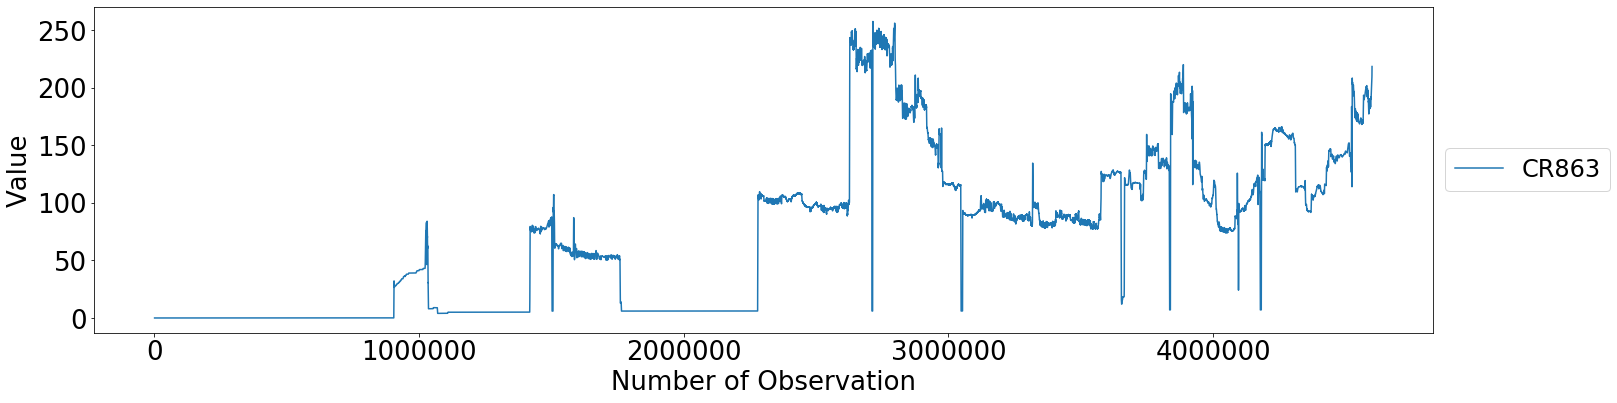

In [29]:
col = "CR863"
plot_dataset(test_df[[col]][:4599965])

In [30]:
len(test_df)

9199930

## Random Selection on real data

In [36]:
n_chunks = 20

In [32]:
sample_data = test_df[[col]][:4599965]
for i in range(1):
    sample_data = sample_data[[col]].append(sample_data[[col]], ignore_index=True)


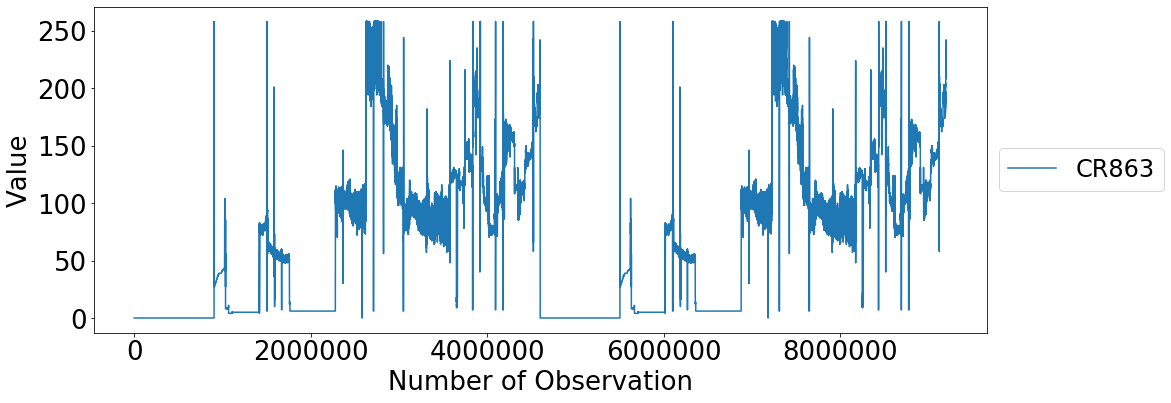

In [373]:
plot_dataset(sample_data)

In [33]:
len(sample_data)

9199930

In [37]:
for chunk in np.array_split(sample_data, n_chunks):
    print(len(chunk))
    break

459997


In [375]:
extended_data = pd.DataFrame()
for chunk in np.array_split(sample_data, n_chunks):
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
    extended_data = extended_data.append(chunk, ignore_index=True)
print(len(chunk))

459996


In [376]:
len(extended_data)

91999300

In [394]:
#extended_data.to_csv("real_data_extended.csv")

In [18]:
extended_data = pd.read_csv("real_data_extended.csv", index_col=0)

C:\Users\iRacheva\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [19]:
extended_data.head()

CR863
0      0
1      0
2      0
3      0
4      0

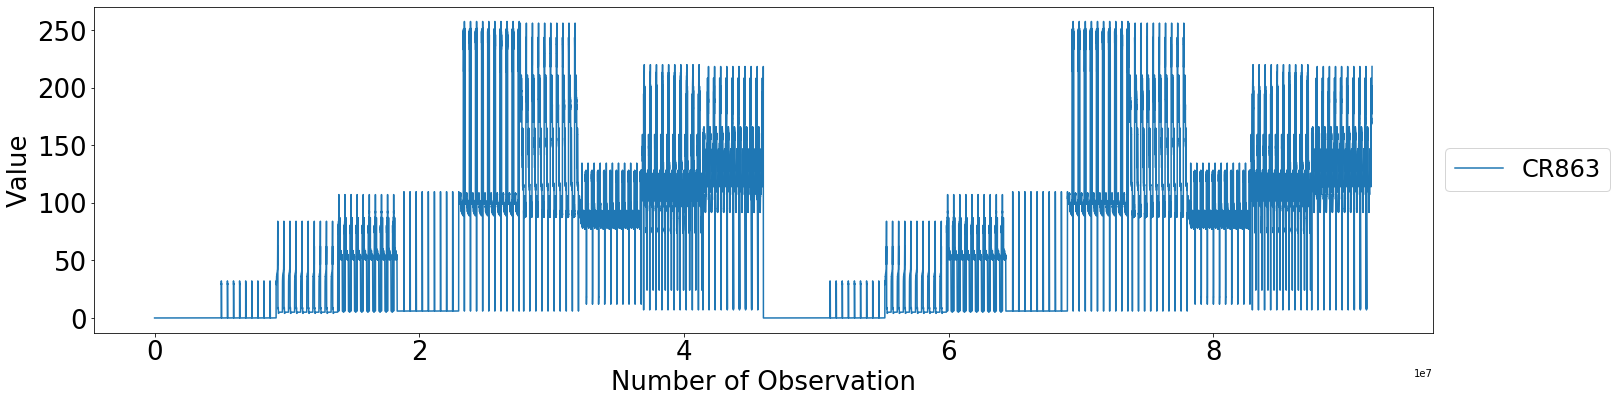

In [24]:
plot_dataset(extended_data)

In [123]:
n_chunks =  2000
for chunk in np.array_split(extended_data, n_chunks):
    print(len(chunk))
    break

46000


Arm_counts {'quick_sort': 670, 'merge_sort': 630, 'heap_sort': 700}
Total reward -5.904311700021026


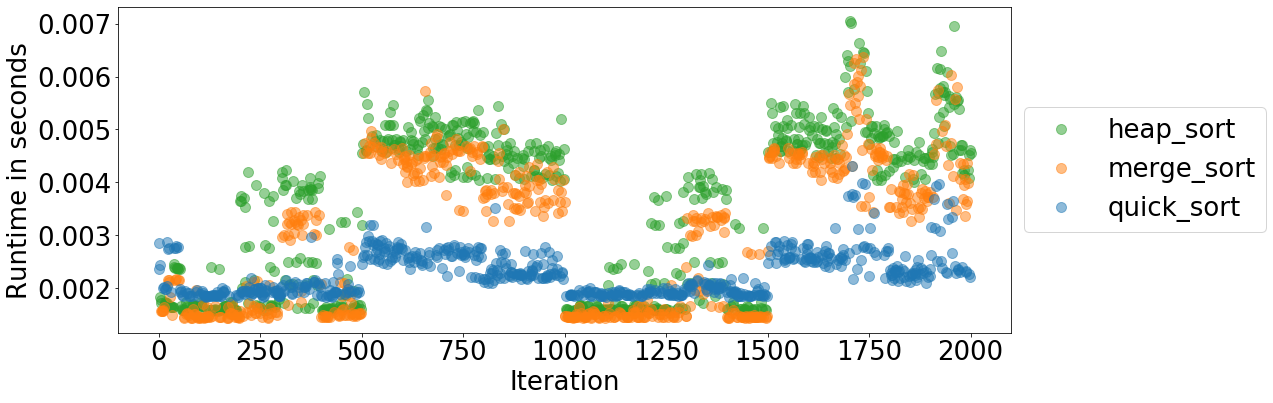

In [131]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history = random_selection(extended_data, n_chunks = n_chunks, col = col)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)

Arm_counts {'quick_sort': 630, 'merge_sort': 668, 'heap_sort': 702}
Total reward -6.798210799991466


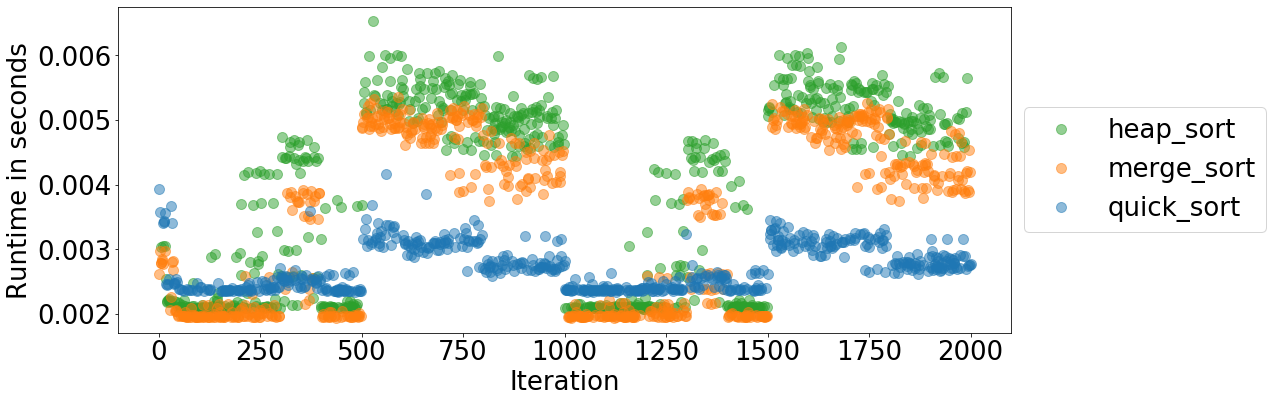

In [125]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history = random_selection(extended_data, n_chunks = n_chunks, col = col)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)

Arm_counts {'quick_sort': 674, 'merge_sort': 661, 'heap_sort': 665}
Total reward -6.473458300002676


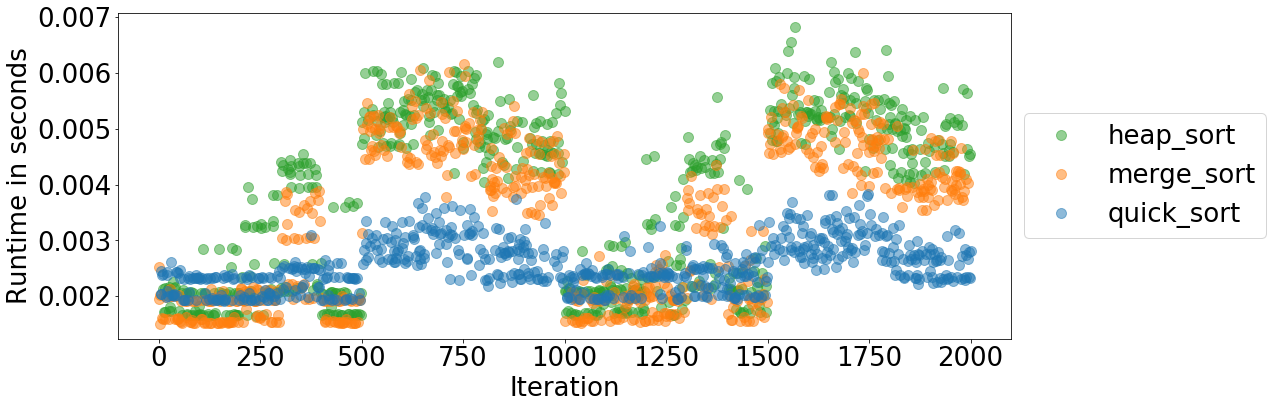

In [132]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history = random_selection(extended_data, n_chunks = n_chunks, col = col)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)

## UCB on real data

Arm_counts {'quick_sort': 1218, 'merge_sort': 750, 'heap_sort': 32}
Total reward -5.663375300016014
Number of restarts 10 in iterations: [47, 156, 391, 401, 501, 699, 1002, 1303, 1502, 1561]


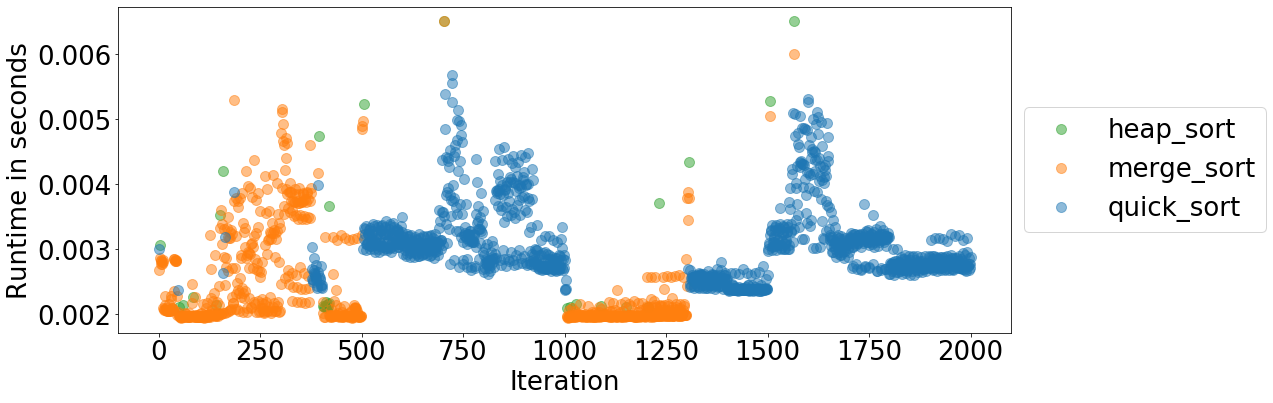

In [90]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 1387, 'merge_sort': 599, 'heap_sort': 14}
Total reward -5.264210000015737
Number of restarts 6 in iterations: [303, 502, 1002, 1303, 1502, 1800]


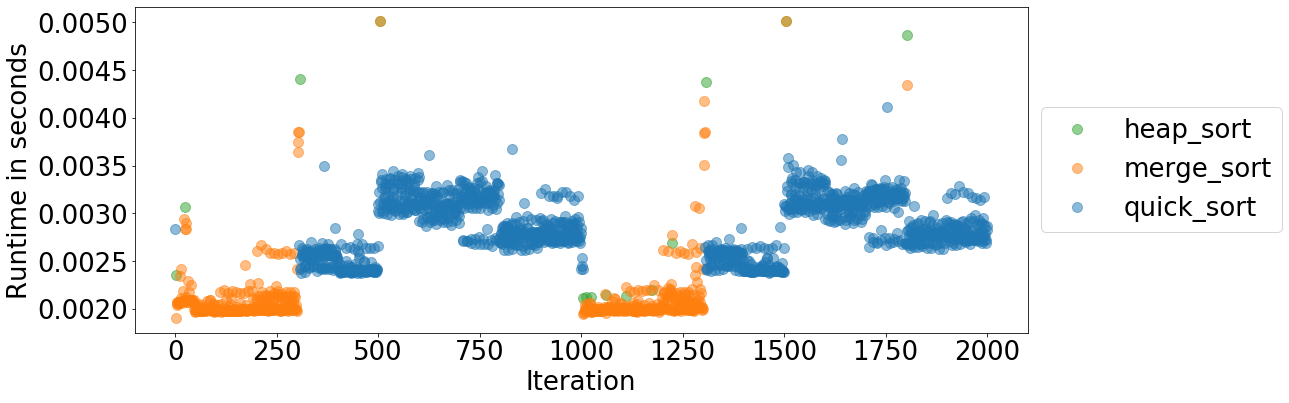

In [91]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 1380, 'merge_sort': 608, 'heap_sort': 12}
Total reward -5.293084100007945
Number of restarts 6 in iterations: [303, 506, 1395, 1648, 1709, 1719]


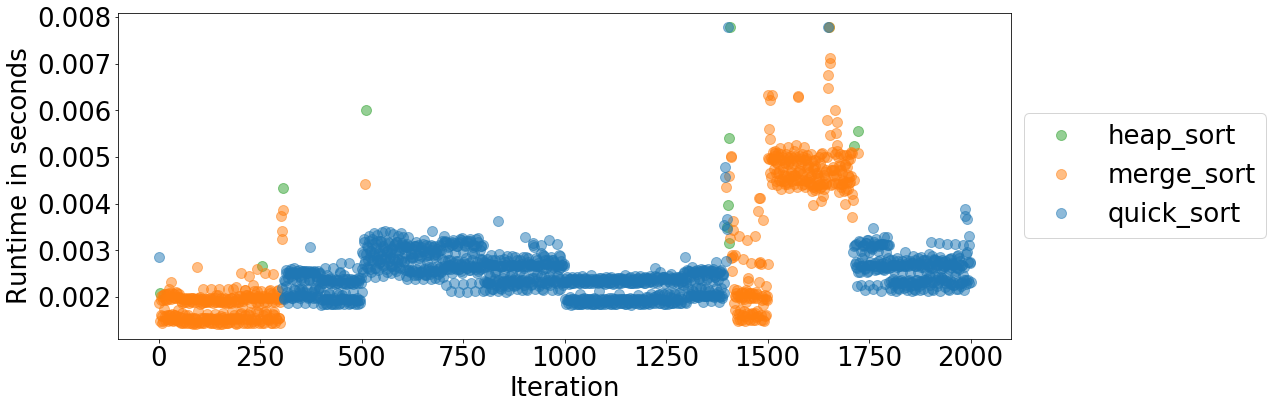

In [92]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 1276, 'merge_sort': 690, 'heap_sort': 34}
Total reward -5.266563299996051
Number of restarts 15 in iterations: [49, 305, 501, 511, 521, 531, 619, 913, 1002, 1303, 1403, 1502, 1521, 1531, 1616]


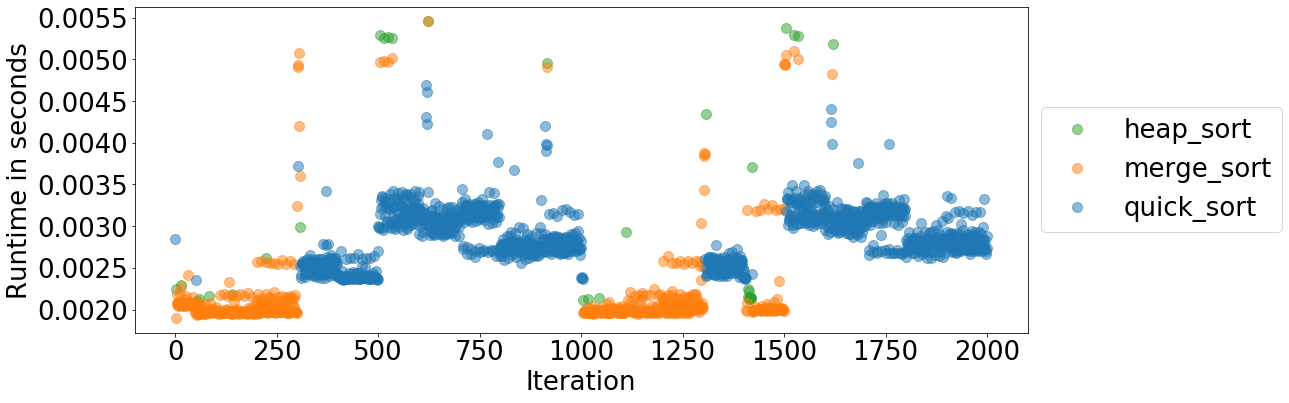

In [93]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 1283, 'merge_sort': 689, 'heap_sort': 28}
Total reward -4.223753499979466
Number of restarts 7 in iterations: [53, 306, 502, 1002, 1303, 1401, 1505]


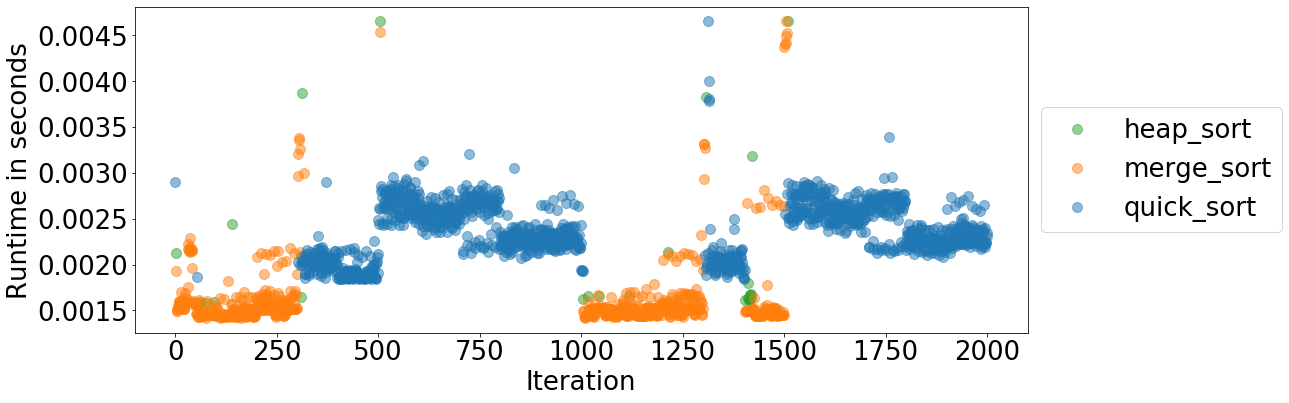

In [94]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 1691, 'merge_sort': 305, 'heap_sort': 4}
Total reward -4.891940099983003
Number of restarts 3 in iterations: [303, 506, 1505]


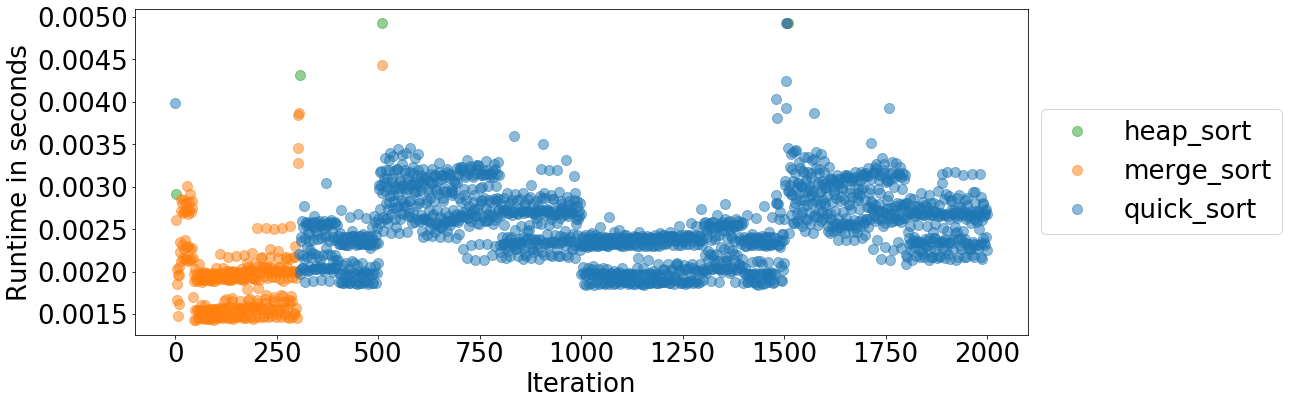

In [95]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 1281, 'merge_sort': 687, 'heap_sort': 32}
Total reward -5.418135900013112
Number of restarts 11 in iterations: [70, 246, 403, 502, 529, 541, 551, 561, 1002, 1303, 1502]


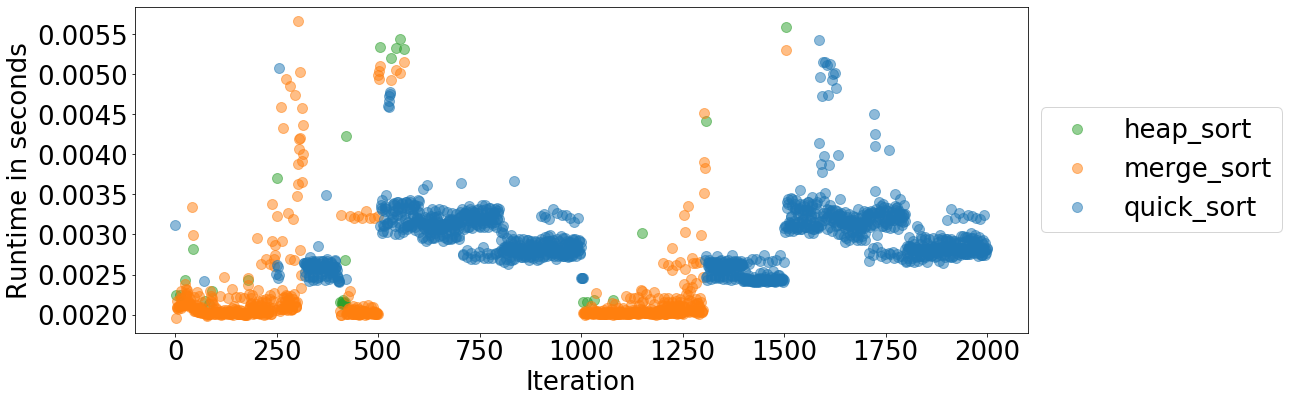

In [133]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 1188, 'merge_sort': 719, 'heap_sort': 93}
Total reward -4.266635499986478
Number of restarts 17 in iterations: [52, 303, 401, 500, 510, 800, 1002, 1012, 1034, 1304, 1404, 1460, 1504, 1521, 1541, 1759, 1769]


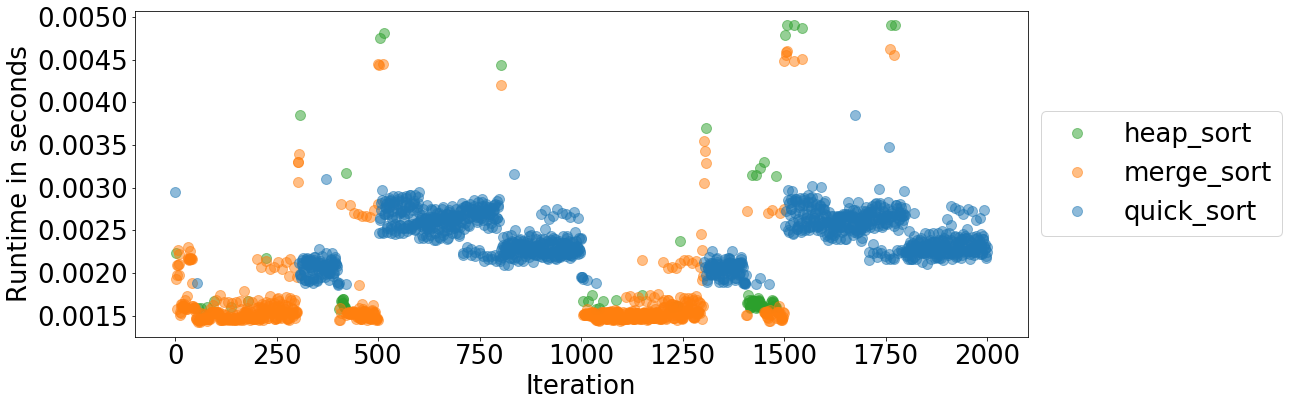

In [97]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 1361, 'merge_sort': 620, 'heap_sort': 19}
Total reward -5.472540699982346
Number of restarts 7 in iterations: [45, 166, 303, 502, 1002, 1305, 1479]


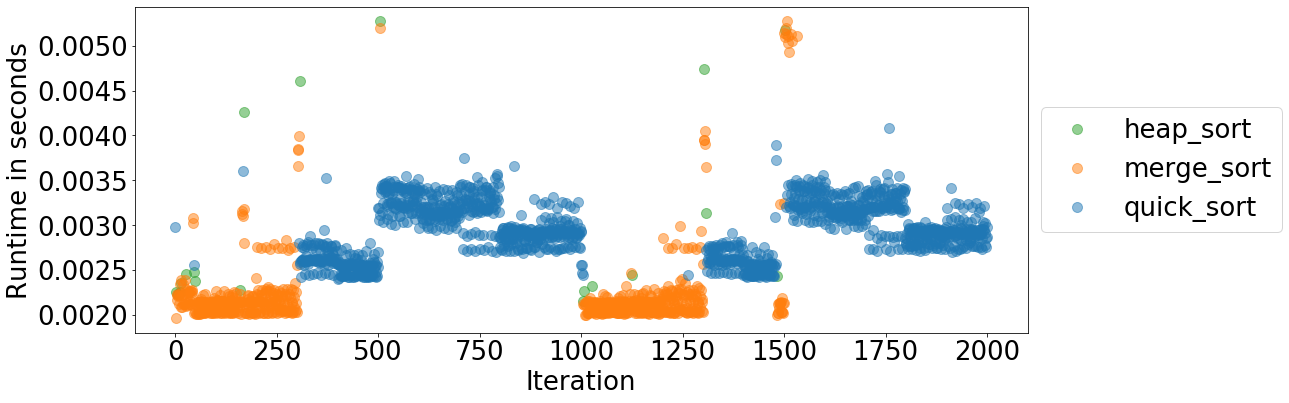

In [98]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 1091, 'merge_sort': 834, 'heap_sort': 75}
Total reward -4.291384299992387
Number of restarts 14 in iterations: [55, 283, 401, 502, 649, 1006, 1303, 1401, 1501, 1511, 1521, 1531, 1559, 1822]


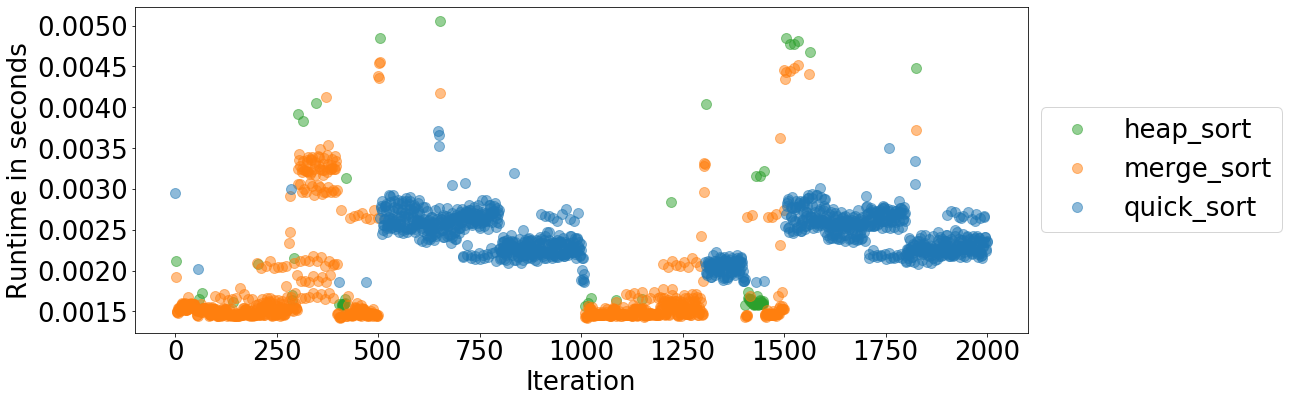

In [99]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 1604, 'merge_sort': 376, 'heap_sort': 20}
Total reward -4.8541659999982585
Number of restarts 4 in iterations: [16, 303, 410, 501]


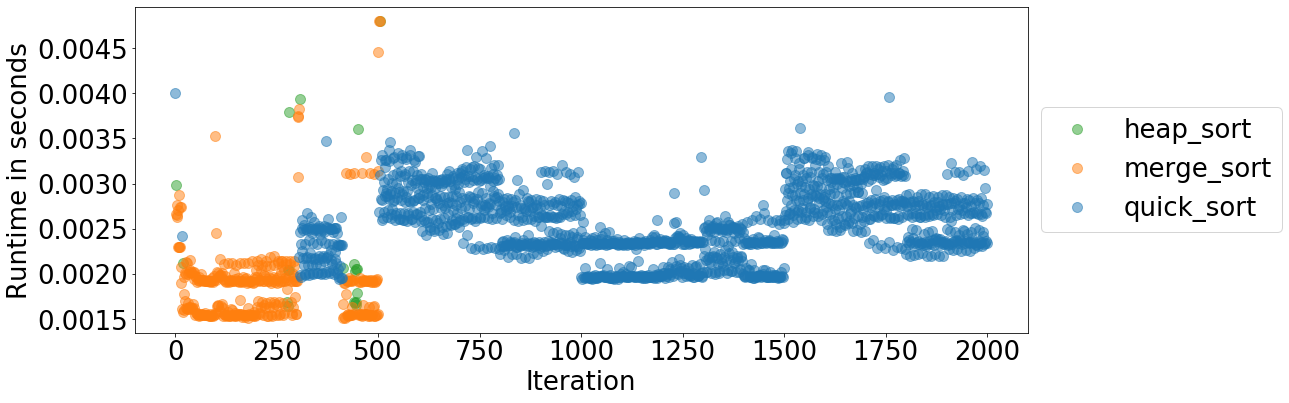

In [100]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.05)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 1295, 'merge_sort': 438, 'heap_sort': 267}
Total reward -5.3138681000191355
Number of restarts 11 in iterations: [201, 303, 502, 1002, 1061, 1303, 1405, 1501, 1511, 1531, 1759]


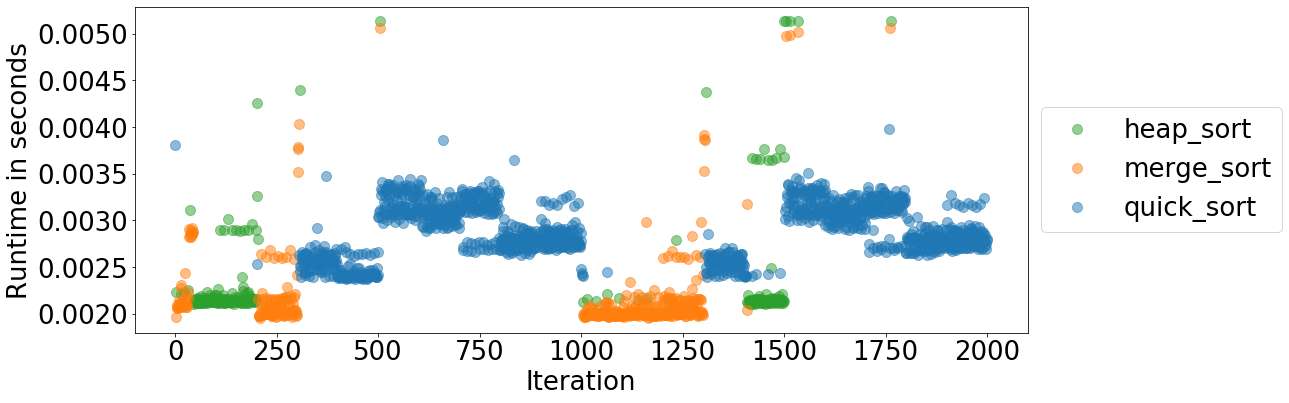

In [101]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.05)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 1198, 'merge_sort': 613, 'heap_sort': 189}
Total reward -4.273207300002468
Number of restarts 18 in iterations: [72, 303, 413, 427, 504, 719, 729, 1002, 1204, 1227, 1259, 1305, 1401, 1501, 1511, 1759, 1769, 1901]


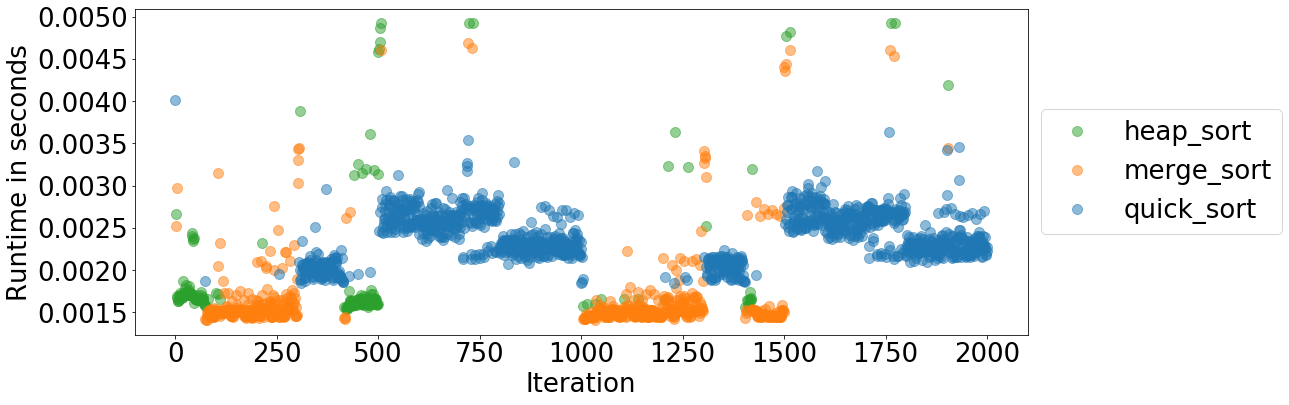

In [102]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.05)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 1693, 'merge_sort': 209, 'heap_sort': 98}
Total reward -4.900147999993351
Number of restarts 4 in iterations: [12, 303, 502, 1975]


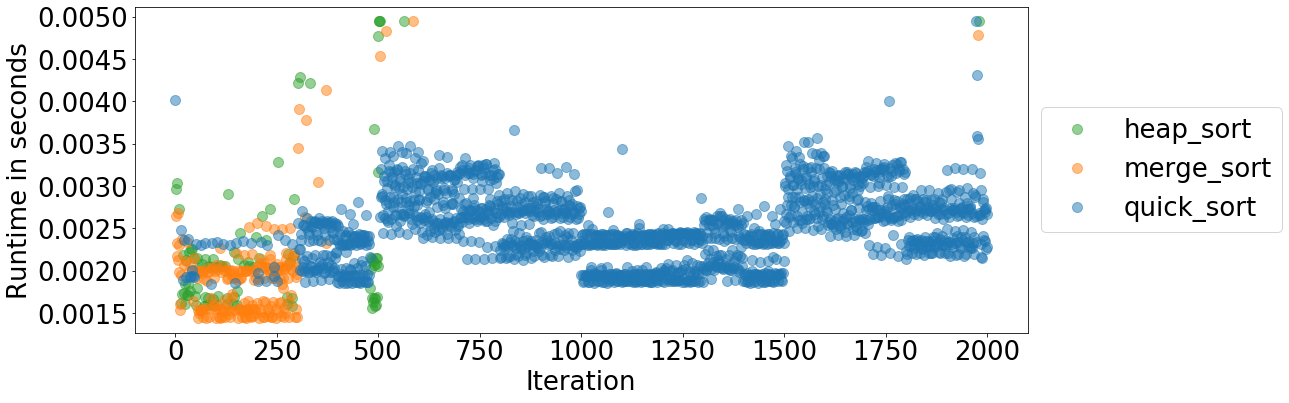

In [103]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 1306, 'merge_sort': 548, 'heap_sort': 146}
Total reward -4.625078500024756
Number of restarts 11 in iterations: [56, 82, 101, 306, 401, 501, 1110, 1502, 1685, 1800, 1911]


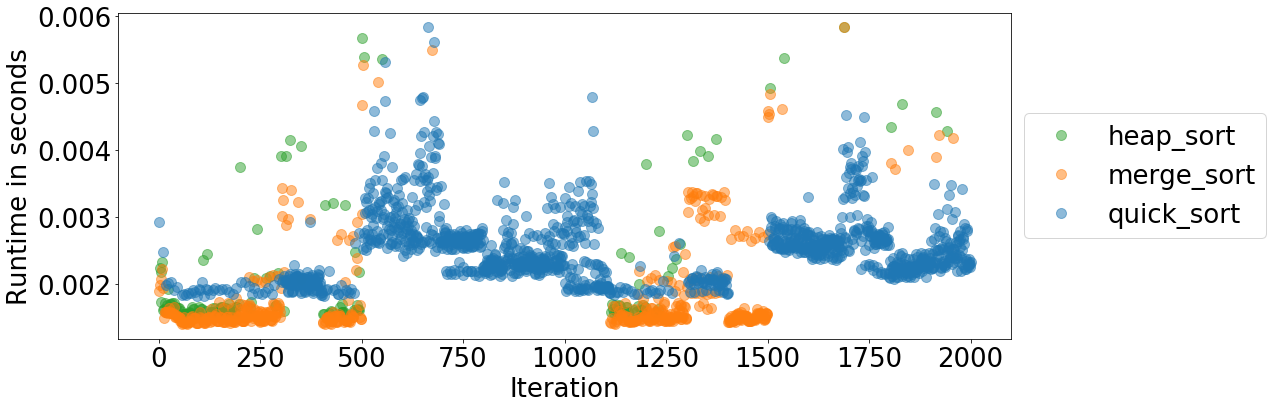

In [104]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

In [135]:
n_chunks =  500
for chunk in np.array_split(extended_data, n_chunks):
    print(len(chunk))
    break

183999


Arm_counts {'quick_sort': 180, 'merge_sort': 155, 'heap_sort': 165}
Total reward -8.036571199991158


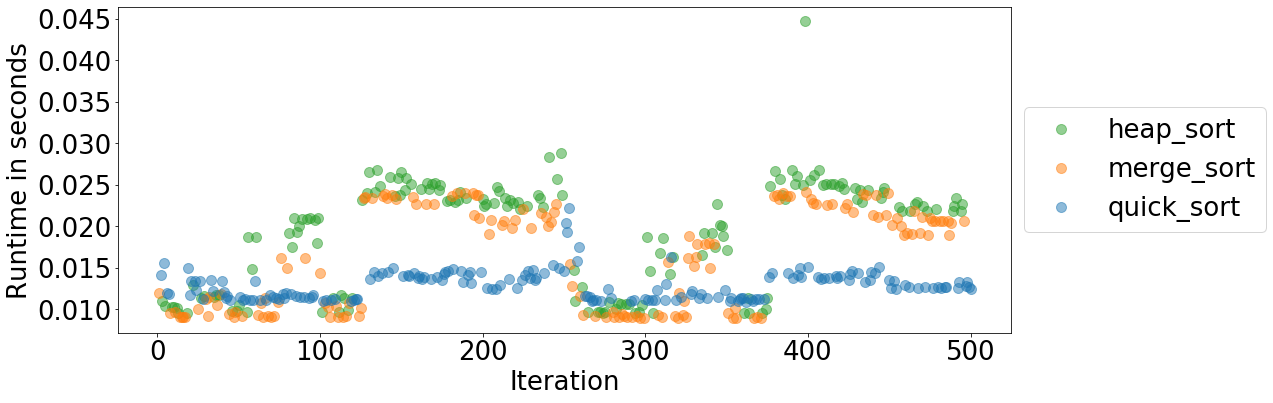

In [143]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history = random_selection(extended_data, n_chunks = n_chunks, col = col)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)

Arm_counts {'quick_sort': 175, 'merge_sort': 169, 'heap_sort': 156}
Total reward -8.366217099995083


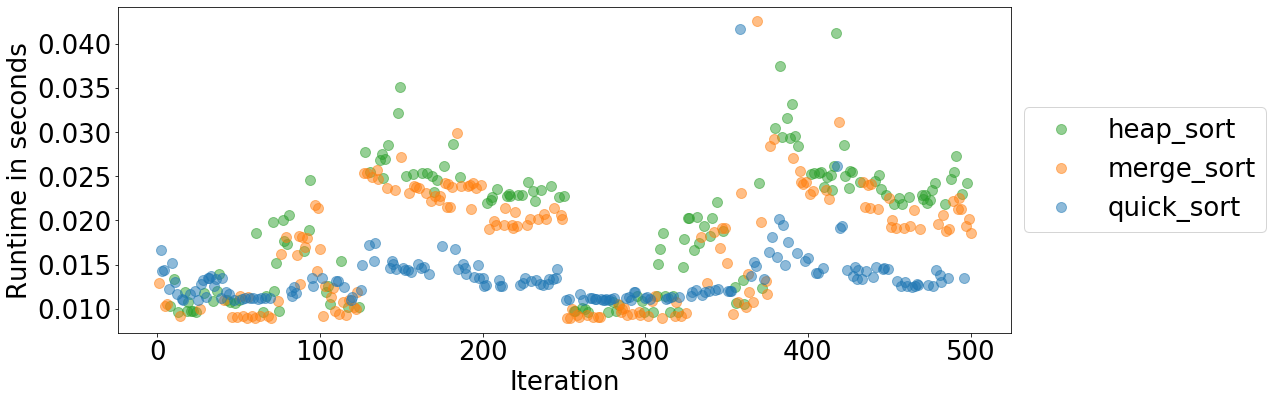

In [142]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history = random_selection(extended_data, n_chunks = n_chunks, col = col)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)

Arm_counts {'quick_sort': 166, 'merge_sort': 170, 'heap_sort': 164}
Total reward -8.090164400002323


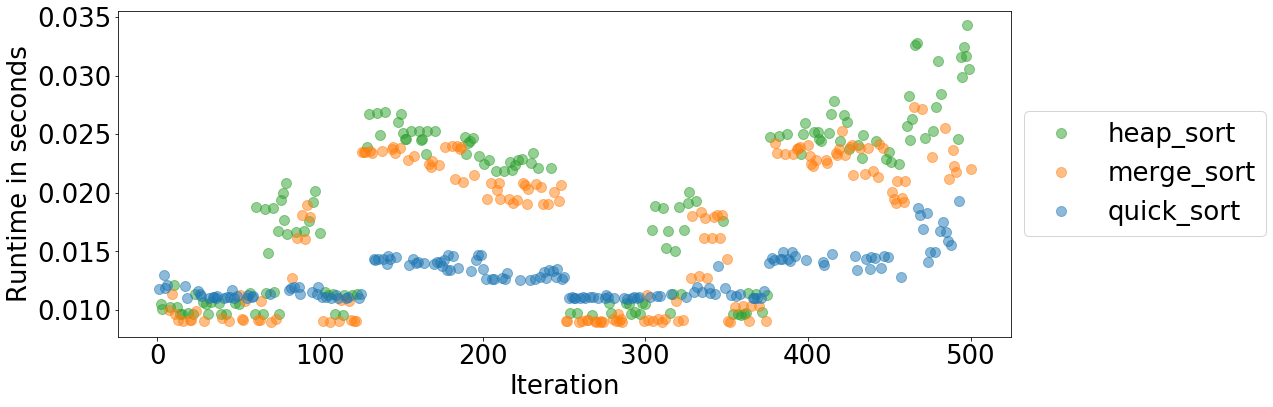

In [108]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history = random_selection(extended_data, n_chunks = n_chunks, col = col)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)

Arm_counts {'quick_sort': 168, 'merge_sort': 165, 'heap_sort': 167}
Total reward -8.107560499996907


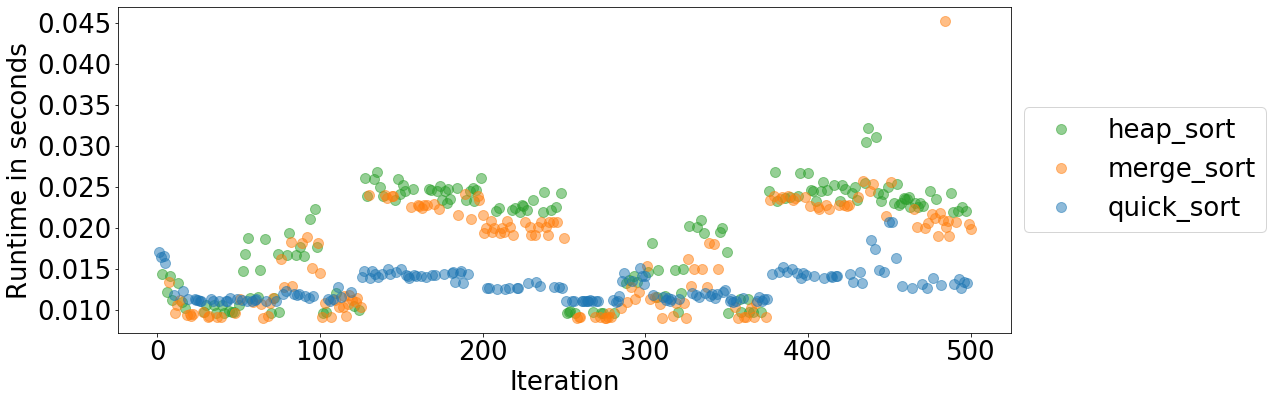

In [109]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history = random_selection(extended_data, n_chunks = n_chunks, col = col)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)

Arm_counts {'quick_sort': 348, 'merge_sort': 144, 'heap_sort': 8}
Total reward -6.229759499994543
Number of restarts 5 in iterations: [76, 259, 329, 377, 452]


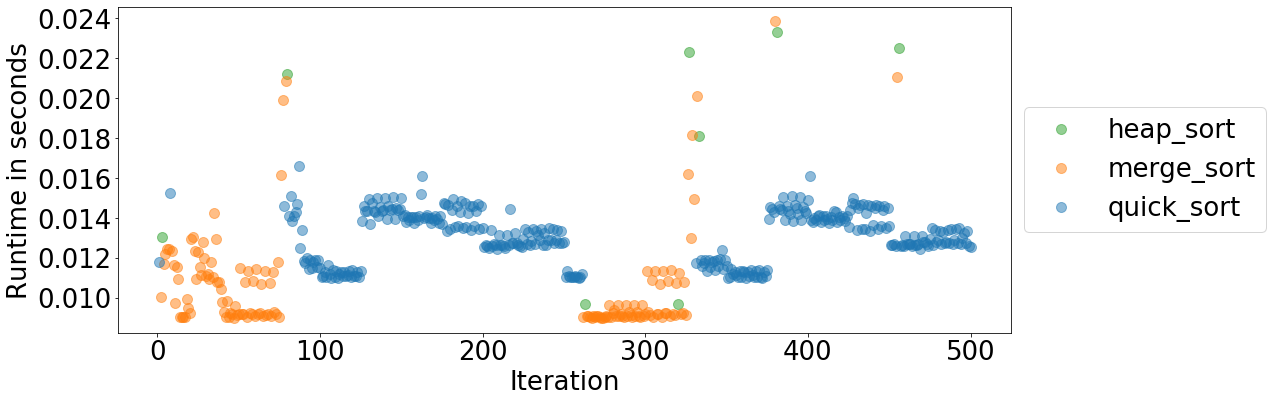

In [110]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 408, 'merge_sort': 75, 'heap_sort': 17}
Total reward -6.7589115999926435
Number of restarts 12 in iterations: [13, 65, 76, 149, 160, 178, 205, 216, 229, 242, 458, 468]


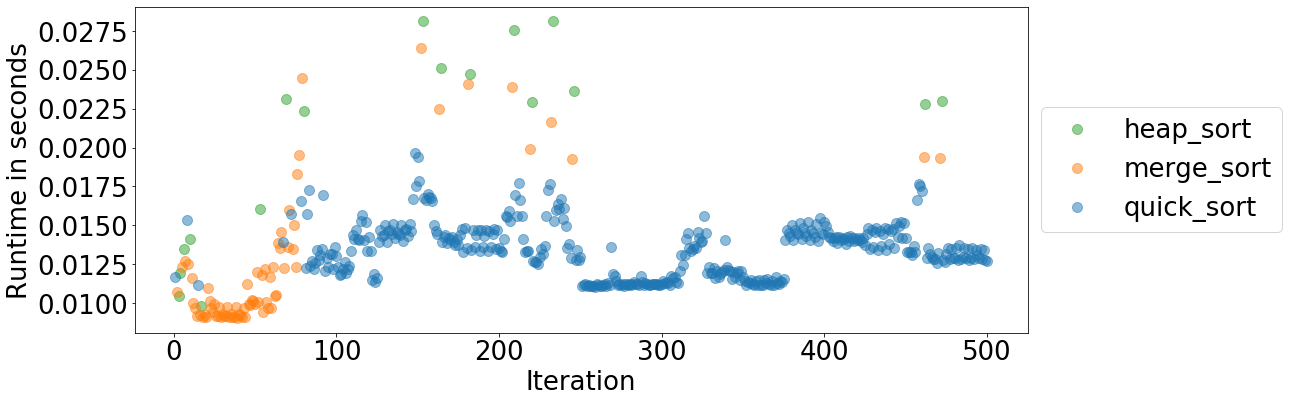

In [139]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 365, 'merge_sort': 125, 'heap_sort': 10}
Total reward -6.444559599995046
Number of restarts 6 in iterations: [14, 127, 202, 225, 377, 452]


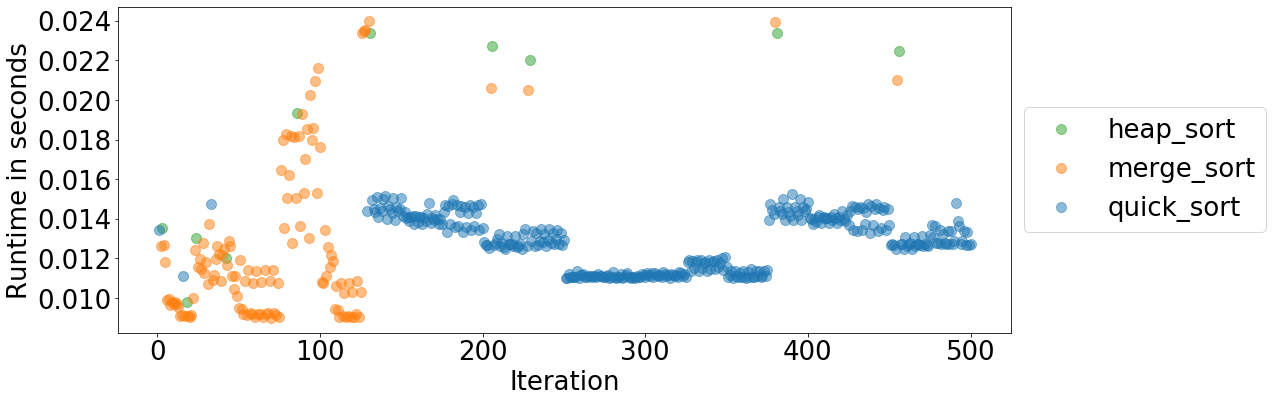

In [140]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 332, 'merge_sort': 156, 'heap_sort': 12}
Total reward -6.1543518999960725
Number of restarts 8 in iterations: [55, 127, 202, 252, 328, 338, 377, 452]


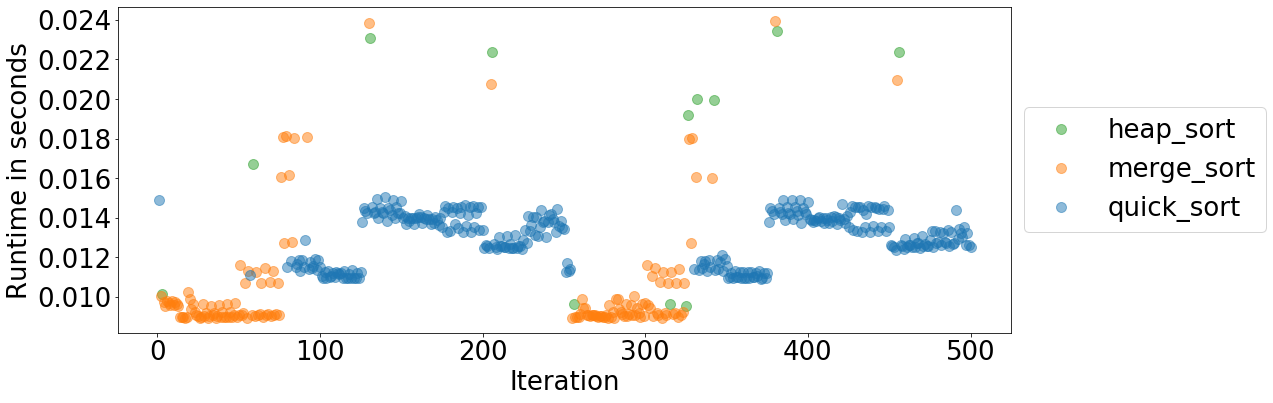

In [141]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 327, 'merge_sort': 160, 'heap_sort': 13}
Total reward -6.202302800003054
Number of restarts 10 in iterations: [60, 127, 202, 252, 329, 377, 391, 401, 422, 452]


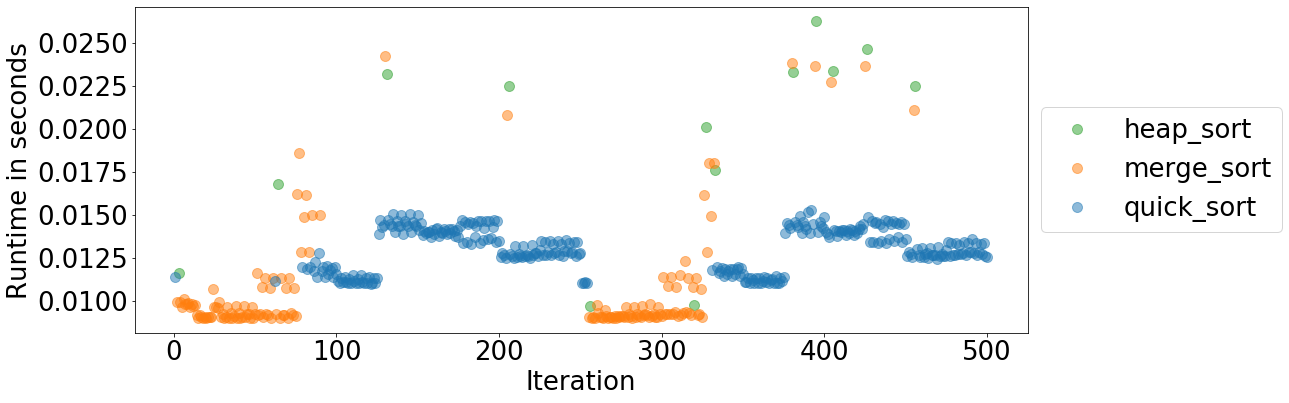

In [114]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.05)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 304, 'merge_sort': 171, 'heap_sort': 25}
Total reward -6.196981900022365
Number of restarts 8 in iterations: [9, 79, 102, 202, 252, 329, 377, 452]


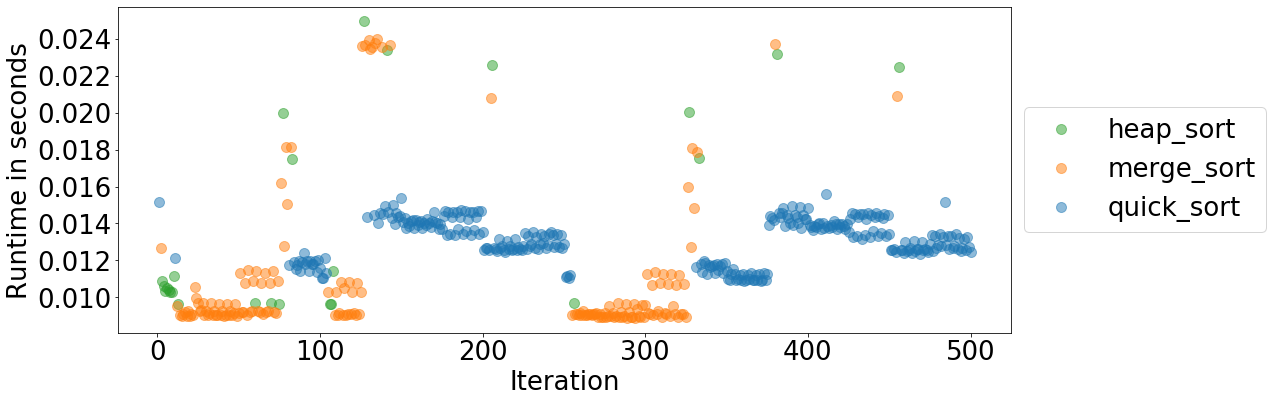

In [115]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.05)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 334, 'merge_sort': 153, 'heap_sort': 13}
Total reward -6.144547399996554
Number of restarts 8 in iterations: [15, 79, 127, 202, 252, 330, 377, 452]


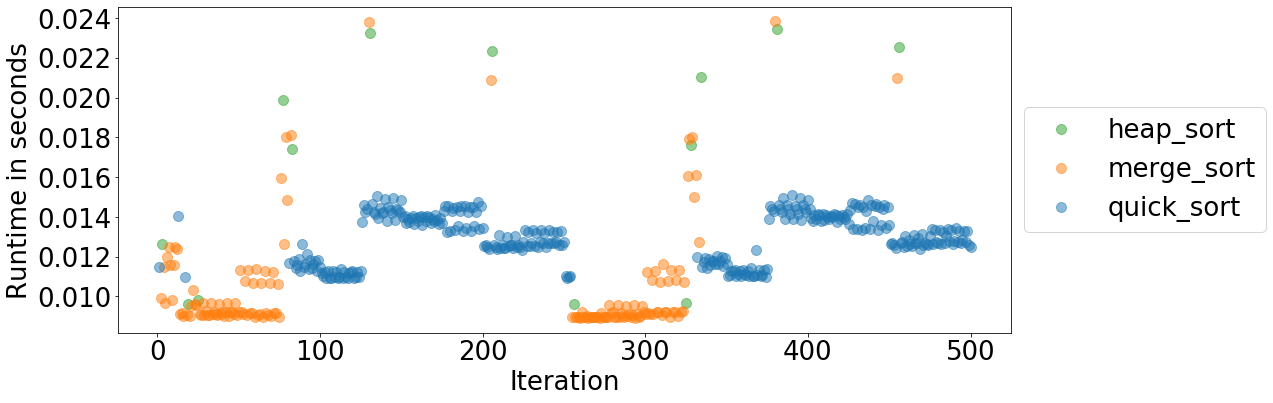

In [116]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.05)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_reinstarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 292, 'merge_sort': 186, 'heap_sort': 22}
Total reward -6.639882699986629
Number of restarts 13 in iterations: [13, 77, 127, 208, 225, 235, 249, 266, 305, 351, 381, 396, 452]


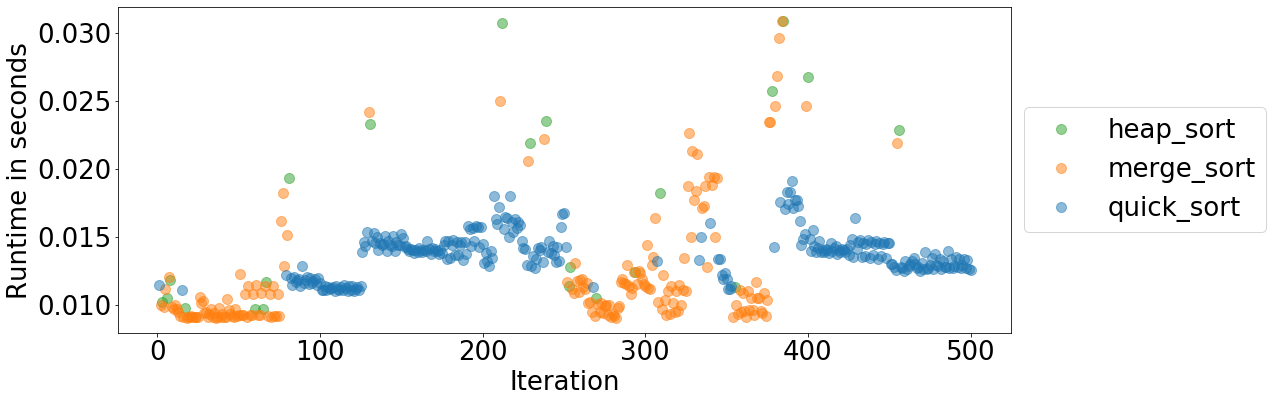

In [137]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.05)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 310, 'merge_sort': 179, 'heap_sort': 11}
Total reward -6.444595300016772
Number of restarts 9 in iterations: [77, 127, 217, 252, 327, 351, 377, 400, 466]


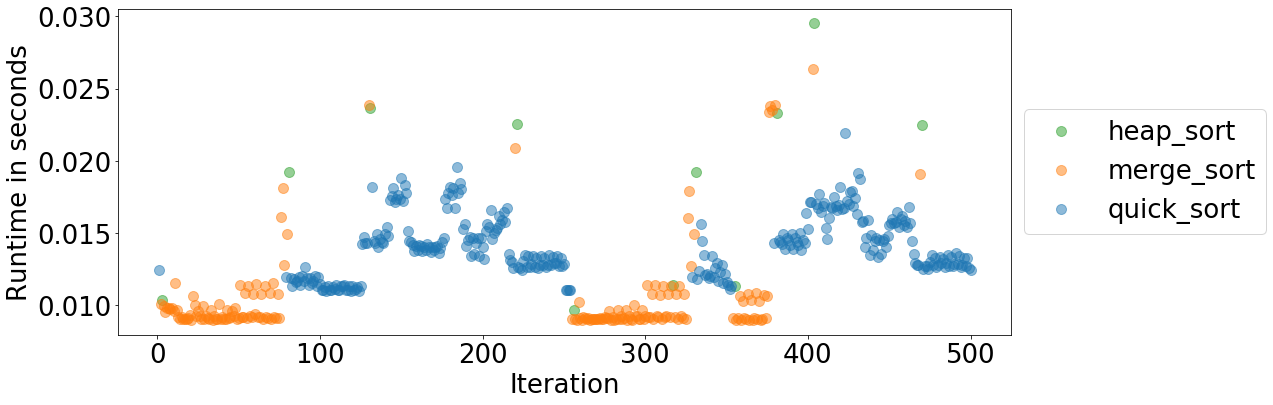

In [118]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(extended_data, n_chunks = n_chunks, col = col, bound_const=0.0001, quantile=0.05)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 1092, 'merge_sort': 759, 'heap_sort': 149}
Total reward -6.007135200020457
Number of restarts 6 in iterations: [164, 305, 427, 504, 1016, 1455]


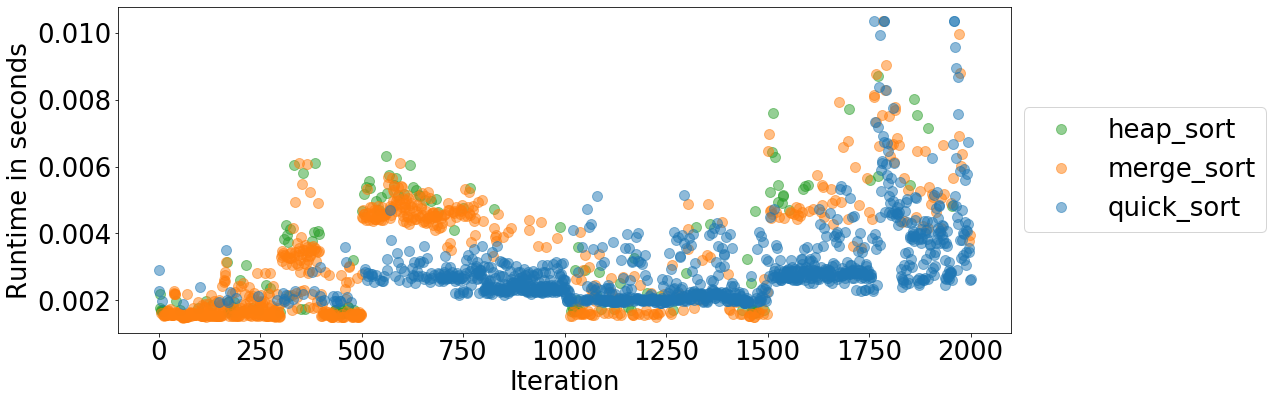

In [134]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = thompson_sampling(extended_data, n_chunks = n_chunks, col = col, num_consec_elem=5, var_multiplier=1, quantile=0.025)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

Arm_counts {'quick_sort': 965, 'merge_sort': 945, 'heap_sort': 90}
Total reward -6.31831729995065


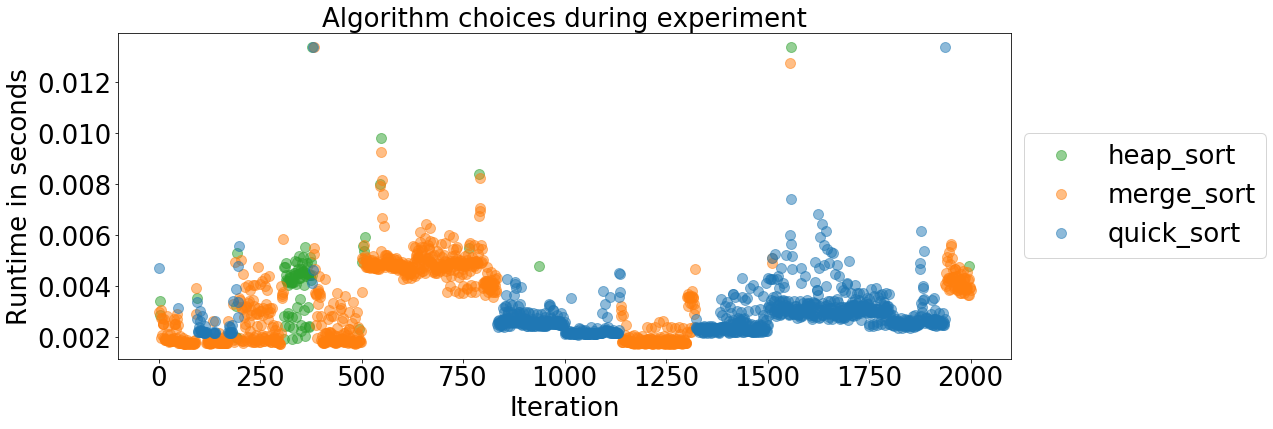

In [409]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history = epsilon_greedy(extended_data, n_chunks = n_chunks, col = col, epsilon=0.01, constant_value=0.9)
plot_history_iterations(history)
print("Arm_counts", arm_counts)
print("Total reward", total_reward)